In [1]:
%matplotlib inline
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from math import sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [3]:
country_name = "Israel"
col_name = 'new_cases_smoothed_per_million'
WINDOW_SIZE = 3
LAG_DAY = 0
epoch_num = 500
predict_startdate = '2021-01-08'
predict_enddate = '2021-12-31'


In [4]:
#Filter Data
df=pd.read_excel('2022owid-covid-data.xlsx')


df['date'] = pd.to_datetime(df['date'])
df1=df[df['location']==country_name]


#before vaccines
df2=df1[df1['date']<='2021-01-10']




#Before vaccines

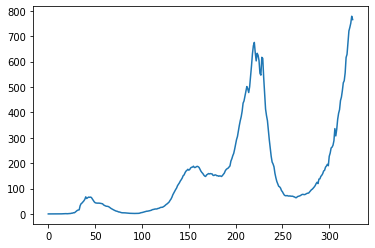

In [5]:
import numpy as np

%matplotlib inline
#df_array=df2[col_name].values
#df_array[np.isnan(df_array)] = 0
dataset=df2[col_name].values
dataset[np.isnan(dataset)] = 0

#normalize data
#norm = np.linalg.norm(dataset)
#dataset = dataset/norm

#scaler
#scaler = MinMaxScaler(feature_range = (0,1))
#dataset_reshape  = df_array.reshape(len(df_array), 1)
#dataset_trans = scaler.fit_transform(dataset_reshape)
#dataset = dataset_trans.reshape(326)

#dataset = dataset.astype('float32')
plt.plot(dataset)
plt.show()



In [6]:
import numpy as np

def df_to_X_y(df, window_size, lag_day):
  X = []
  y = []
  for i in range(len(df)- window_size - lag_day):
    row = [[a] for a in df[i:i+window_size]]
    X.append(row)
    if i+window_size+lag_day < len(df):
      label = df[i+window_size+lag_day]
      y.append(label)
    else:
      break
  return np.array(X), np.array(y)


X1, y1 = df_to_X_y(dataset, WINDOW_SIZE, LAG_DAY)


In [7]:
X_train1, y_train1 = X1[:160], y1[:160]
X_val1, y_val1 = X1[160:255], y1[160:255]
X_test1, y_test1 = X1[255:], y1[255:]

'''
X_train1, y_train1 = X1[:193], y1[:193]
X_val1, y_val1 = X1[193:258], y1[193:258]
X_test1, y_test1 = X1[258:], y1[258:]
'''

X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape


((160, 3, 1), (160,), (95, 3, 1), (95,), (68, 3, 1), (68,))

In [8]:
#DNN
def model_dnn(WINDOW_SIZE):
  model1 = Sequential()
  model1.add(Dense(64,input_dim=WINDOW_SIZE,activation='relu'))
  model1.add(Dropout(0.2))
  model1.add(Dense(8, 'linear'))
  model1.add(Dense(1, 'linear'))
  model1.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse','mae'])
  return model1


model1=model_dnn(WINDOW_SIZE)
model1.summary
cp1 = ModelCheckpoint('model1/', save_best_only=True,monitor='val_loss')
#early_stopping=EarlyStopping(monitor='val_loss',mode='min',verbose=0.3,patience=50)
history=model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), 
                   epochs=epoch_num,callbacks=[cp1],verbose=1,shuffle=False)

Epoch 1/500
5/5 [==============================] - 4s 338ms/step - loss: 1317.2771 - mse: 1317.2771 - mae: 22.5826 - val_loss: 26334.9102 - val_mse: 26334.9102 - val_mae: 136.0078
Epoch 2/500
5/5 [==============================] - 1s 209ms/step - loss: 1287.6216 - mse: 1287.6216 - mae: 19.5091 - val_loss: 12940.5459 - val_mse: 12940.5459 - val_mae: 94.1142
Epoch 3/500
5/5 [==============================] - 1s 212ms/step - loss: 827.6582 - mse: 827.6582 - mae: 14.6507 - val_loss: 4563.3159 - val_mse: 4563.3159 - val_mae: 52.9967
Epoch 4/500
5/5 [==============================] - 1s 211ms/step - loss: 700.6837 - mse: 700.6837 - mae: 12.4496 - val_loss: 1045.4531 - val_mse: 1045.4531 - val_mae: 22.8758
Epoch 5/500
5/5 [==============================] - 1s 215ms/step - loss: 255.1893 - mse: 255.1893 - mae: 8.5918 - val_loss: 923.5099 - val_mse: 923.5099 - val_mae: 19.2307
Epoch 6/500
5/5 [==============================] - 0s 14ms/step - loss: 604.0958 - mse: 604.0958 - mae: 12.5648 - val_l

In [9]:
#Evaluation
def model_loss(history):
  plt.figure(figsize=(8,4))
  plt.plot(history.history['loss'],label='Train Loss')
  plt.plot(history.history['val_loss'],label='Validation Loss')
  plt.title=(country_name + " " + col_name + " " + 'Model Loss')
  plt.ylabel=('Loss')
  plt.xlabel=('Epochs')
  plt.legend(loc='upper right')
  plt.show();

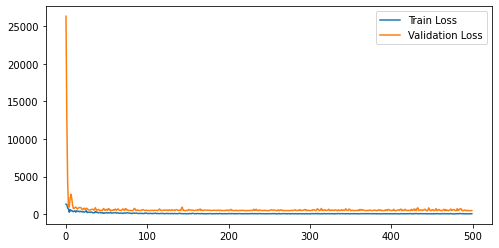

Train Root Mean Squared Error(RMSE): 2.65; Train Mean Absolute Error(MAE): 1.63 
Val Root Mean Squared Error(RMSE): 21.72; Val Mean Absolute Error(MAE): 12.21 
Test Root Mean Squared Error(RMSE): 16.88; Test Mean Absolute Error(MAE): 9.55 


In [10]:
#DNN Eval
train_score=model1.evaluate(X_train1,y_train1,verbose=0)
model_loss(history)
print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE): %.2f ' %(np.sqrt(train_score[1]),train_score[2]))
val_score=model1.evaluate(X_val1,y_val1,verbose=0)
print('Val Root Mean Squared Error(RMSE): %.2f; Val Mean Absolute Error(MAE): %.2f ' %(np.sqrt(val_score[1]),val_score[2]))
test_score=model1.evaluate(X_test1,y_test1,verbose=0)
print('Test Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE): %.2f '% (np.sqrt(test_score[1]),test_score[2]))

Text(0.5, 0, 'Days')

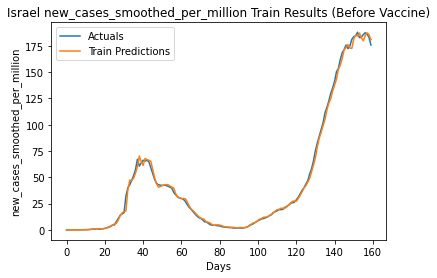

In [11]:
#training results
%matplotlib inline
import matplotlib.pyplot as plt
from imp import reload
reload(plt)

train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results.shape

plt.plot(train_results['Actuals'])
plt.plot(train_results['Train Predictions'])
plt.legend(['Actuals', 'Train Predictions'])

plt.title(country_name + " " + col_name + " " + 'Train Results (Before Vaccine)')
plt.ylabel(col_name)
plt.xlabel("Days")


Text(0.5, 0, 'Days')

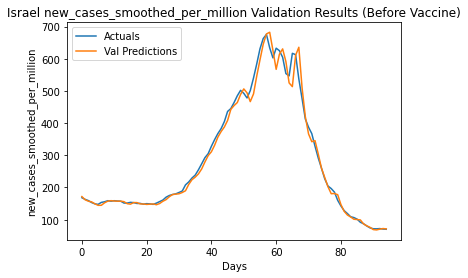

In [12]:
#val results

val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

plt.plot(val_results['Actuals'])
plt.plot(val_results['Val Predictions'])

plt.legend(['Actuals', 'Val Predictions'])

plt.title(country_name + " " + col_name + " " + 'Validation Results (Before Vaccine)')
plt.ylabel(col_name)
plt.xlabel("Days")

Text(0.5, 0, 'Days')

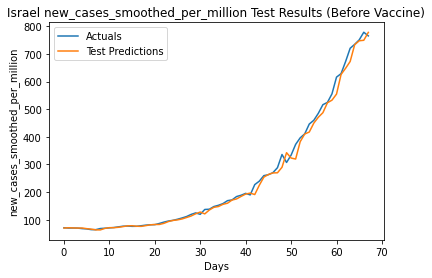

In [13]:
#test results
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

plt.plot(test_results['Actuals'])
plt.plot(test_results['Test Predictions'])

plt.legend(['Actuals', 'Test Predictions'])

plt.title(country_name + " " + col_name + " " + 'Test Results (Before Vaccine)')
plt.ylabel(col_name)
plt.xlabel("Days")

In [14]:
#prediction range up to 2021.12.31

from datetime import date
f_date = date(2021, 1, 8)#!!!
l_date = date(2021, 12, 31)
delta = l_date - f_date



predict_dataset = df1[(df1["date"]>=predict_startdate) & (df1["date"]<='2021-01-10')]#!!!
predict_dataset = predict_dataset[col_name].values


for i in range(delta.days-LAG_DAY-WINDOW_SIZE+1):#- lagday- windowsize +1

  temp = [[predict_dataset[i],predict_dataset[i+1],predict_dataset[i+2]]] #window size
  predict_y = model1.predict(temp).flatten()
  predict_dataset = np.append(predict_dataset,predict_y)



In [15]:
actual_predict = df1[(df1["date"]>=predict_startdate) & (df1["date"]<=predict_enddate)]
actual_predict = actual_predict[col_name].values
len(predict_dataset), len(actual_predict)


(358, 358)

In [16]:
#getting date info
dates = df1[(df1["date"]>=predict_startdate) & (df1["date"]<=predict_enddate)] #!!!window size
dates = dates["date"].values

dates_new = []
for item in dates:
  item= pd.to_datetime(item)
  dates_new.append(str(item.year)+"-"+str(item.month)+"-"+str(item.day))

#create dataframe to set index as date
with_dates = pd.DataFrame(data={'Date': dates_new, 'Predictions':predict_dataset, 'Actuals':actual_predict})
with_dates = with_dates.set_index('Date')


# convert index to datetime
with_dates.index=pd.to_datetime(with_dates.index)

Text(0.5, 0, 'Year-Month')

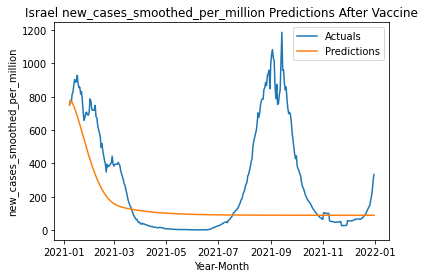

In [18]:
plt.plot(with_dates['Actuals'])
plt.plot(with_dates['Predictions'])

plt.legend(['Actuals', 'Predictions'])

plt.title(country_name + " " + col_name + " " + 'Predictions After Vaccine')
plt.ylabel(col_name)
plt.xlabel("Year-Month")


In [ ]:
model1.save("final_model")

INFO:tensorflow:Assets written to: final_model/assets


In [ ]:


!zip -r /content/final_model.zip /content/final_model



from google.colab import files
files.download("/content/final_model.zip")


updating: content/final_model/ (stored 0%)
updating: content/final_model/keras_metadata.pb (deflated 87%)
updating: content/final_model/variables/ (stored 0%)
updating: content/final_model/variables/variables.data-00000-of-00001 (deflated 43%)
updating: content/final_model/variables/variables.index (deflated 64%)
updating: content/final_model/saved_model.pb (deflated 88%)
updating: content/final_model/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras.models import load_model
model1 = load_model('final_model/')
